# Exercise Sheet 2 - CIFAR, MLP, Overfitting, and Regularization

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Nov 21, before 14:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 2`.
- Make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution into the marked cells.


## Imports

In [4]:
import os
import fastprogress
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

### GPU and Cuda checks

In [5]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [6]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4
2 CPUs available


**Recommendation:** Use GPU or TPU for faster model training. Exercise Sheet 1 explains how to do that on Kaggle.

## Load data

In [7]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=1):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True, 
                                            transform=torchvision.transforms.ToTensor())

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_samples, 
                                              num_workers=num_cpus)
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(data_dir, download=True, train=True, 
                                            transform=normalized_transform) 
    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(data_dir, download=True, train=False, 
                                           transform=normalized_transform)

    return trainset, testset, dataset_mean, dataset_std
        
        
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(trainset, 
                                  (num_train_samples, num_val_samples), 
                                  generator=torch.Generator().manual_seed(split_seed))
    return trainset, valset
    
    
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """        
    trainloader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_cpus)
    valloader = torch.utils.data.DataLoader(valset, 
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=num_cpus)
    testloader = torch.utils.data.DataLoader(testset,
                                                  batch_size=batch_size,
                                                  shuffle=True, 
                                                  num_workers=num_cpus)
    return trainloader, valloader, testloader

#### TODO
- Load the CIFAR 10 train and test data set using the functions defined above
- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.
- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.

*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [8]:
####################
## YOUR CODE HERE ##
####################
seed = 42

trainset, testset, dataset_mean, dataset_std = grab_data('data')
trainset, valset = generate_train_val_data_split(trainset,split_seed=seed)
trainloader, valloader, testloader= init_data_loaders(trainset, valset,testset)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.

#### TODO
- Print all class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [9]:
trainset.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [10]:
def imshow(img, mean, std,ax):
    """Undo normalization using mean and standarddeviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    # Define function to plot
    
    ####################
    ## YOUR CODE HERE ##
    ####################
    img = img.permute(1,2,0)
    ax.imshow(img*std+mean)

In [14]:
X.shape

torch.Size([3, 32, 32])

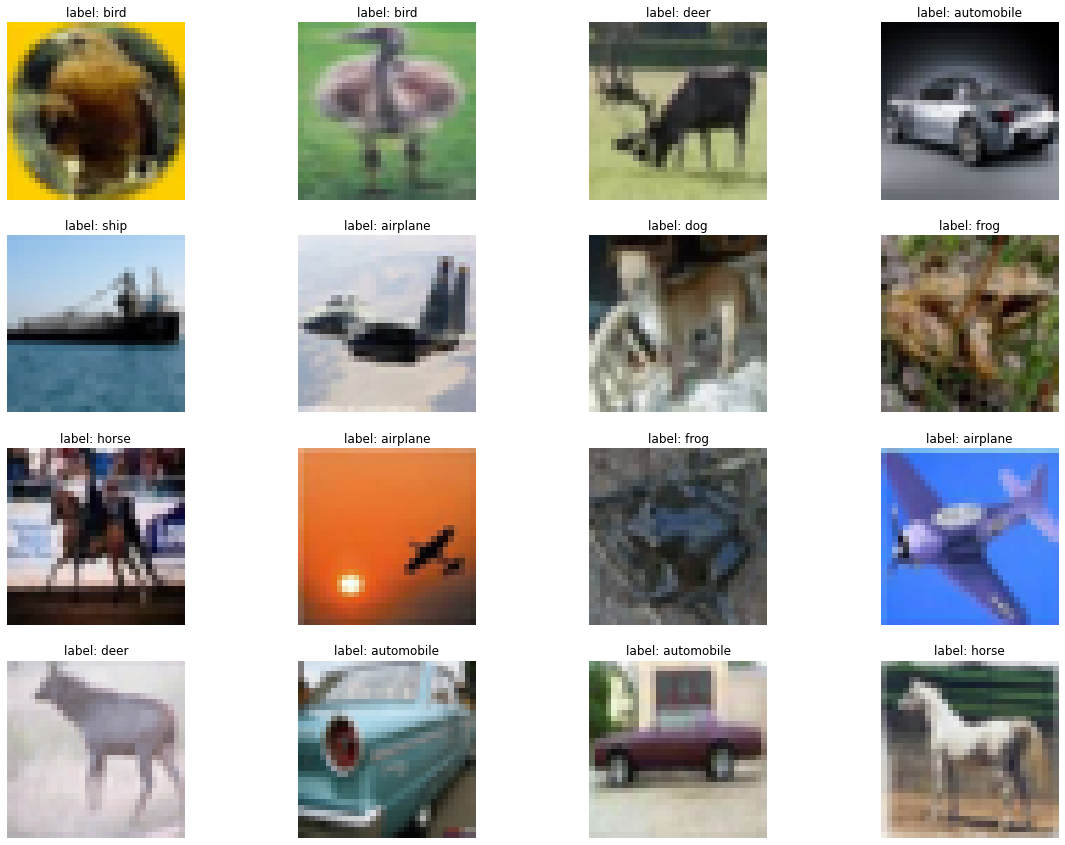

In [16]:
# Create actual plot and print the class names

####################
## YOUR CODE HERE ##
####################
mydict = trainset.dataset.class_to_idx
X,y = next(iter(trainloader))
fig, axes = plt.subplots(4,4, figsize=(20,15))
for ax in axes.flatten():
    ax.axis('off')
    indx = np.random.randint(0,len(X))
    X_ac = X[indx]
    y_ac = y[indx]
    label = list(mydict.keys())[list(mydict.values()).index(y_ac)]
    ax.set_title("label: {}".format(label))
    imshow(X_ac,dataset_mean, dataset_std,ax)

## Training, evaluation and plotting functions from Exercise 1

Here, we provide examples of the functions you implemented on the first exercise sheet to you. Some parts are still missing. You can ignore that for the time being, as you will implement that later as soon as the according functionality is required.

In [17]:
mkdir trained_models

__notebook_source__.ipynb  data/  model  state.db


In [46]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(model, optimizer, loss_function, device, num_epochs, 
                train_dataloader, val_dataloader, early_stopper=None, verbose=False):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]
    if early_stopper:
        if (early_stopper.path!=None):
            if(not os.path.isdir("/kaggle/working/trained_models/")):
                os.chdir("/kaggle/working/")
                os.mkdir("trained_models")
            os.chdir("/kaggle/working/trained_models/")
            if os.path.isdir(early_stopper.path):
                os.system("rm -r "+early_stopper.path)
                os.system("mkdir "+early_stopper.path)
            else:
                os.system("mkdir "+early_stopper.path)
            os.chdir("/kaggle/working/trained_models/"+early_stopper.path)
    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
            
        if early_stopper:
            early_stopper.val_acc.append(epoch_val_acc)
            early_stopper.check()
            if (early_stopper.path!=None):
                torch.save(model.state_dict(),"model_for_epoch_"+str(len(early_stopper.val_acc)))
            if(early_stopper.early_stop):
                if (early_stopper.path!=None):
                    model.load_state_dict(torch.load("model_for_epoch_"+str(len(early_stopper.val_acc)-early_stopper.patience)))
                break
            #raise NotImplementedError # Comment out this keyword after your implementation
            
            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        raise NotImplementedError # Comment out this keyword after your implementation

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [27]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(self, img_width, num_in_channels, num_classes, 
                 num_hidden_units=30, num_hidden_layers=1, act_fn=None):
        super(MLP, self).__init__()
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        self.act_fn = act_fn
        self.hidden = [nn.Linear(img_width * img_width * num_in_channels, num_hidden_units)]
        for k in range(num_hidden_layers-1):
            self.hidden.append(nn.Linear(num_hidden_units, num_hidden_units))
        self.hidden=nn.ModuleList(self.hidden)
        self.out = nn.Linear(num_hidden_units,num_classes)
        
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        m = nn.Flatten()
        x = m(x)
        for layer in self.hidden:
            if(self.act_fn==None):
                x = F.relu(layer(x))
            else:
                x = self.act_fn(layer(x))
        output= self.out(x)

        return output

## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we do not use SGD as in exercise 1, but the commonly used Adam optimizer, since it behaves more robustly and is easy to use.

#### TODO
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

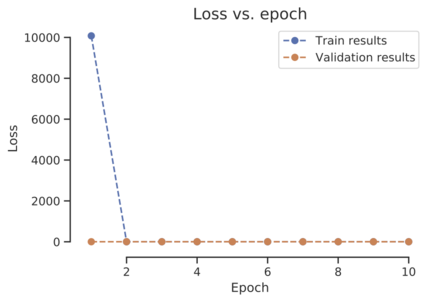

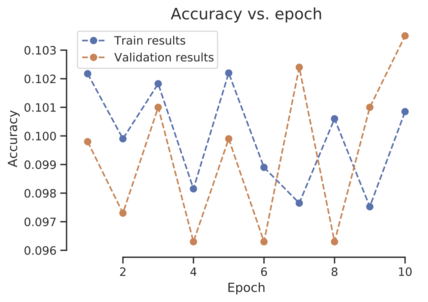

**This is an example of a model that does train:** *(Why?)*

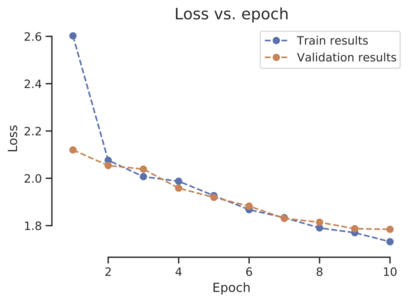

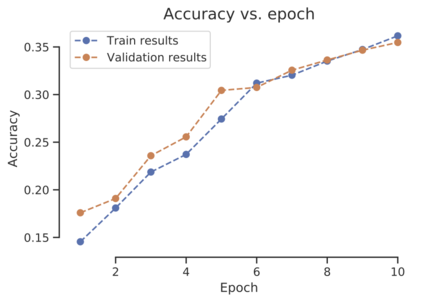

In [28]:
import warnings
warnings.filterwarnings("ignore")

didnt learn for 1 epochs in a row
Finished training after 46 seconds.


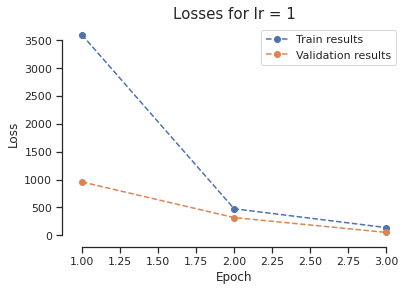

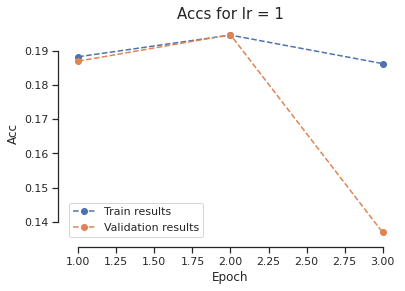

didnt learn for 1 epochs in a row
Finished training after 73 seconds.


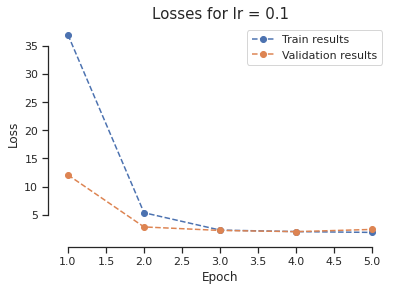

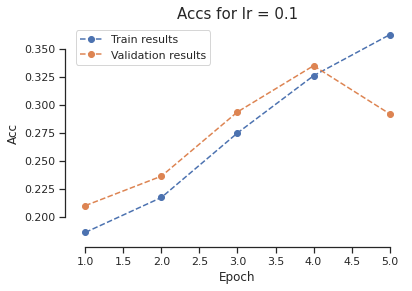

didnt learn for 1 epochs in a row
Finished training after 102 seconds.


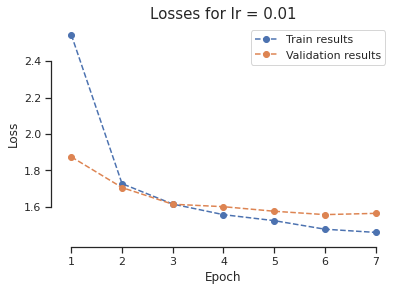

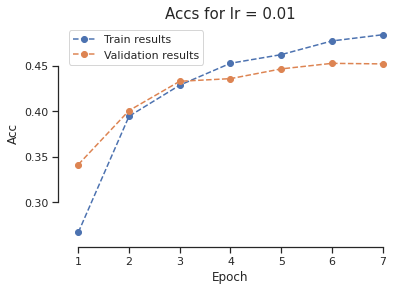

didnt learn for 1 epochs in a row
Finished training after 102 seconds.


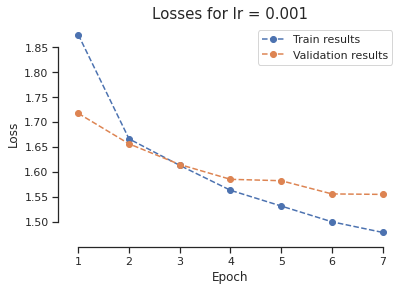

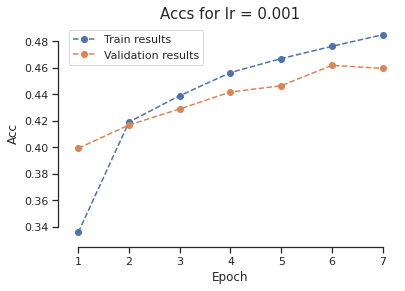

Finished training after 147 seconds.


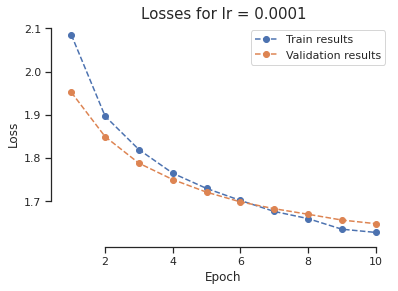

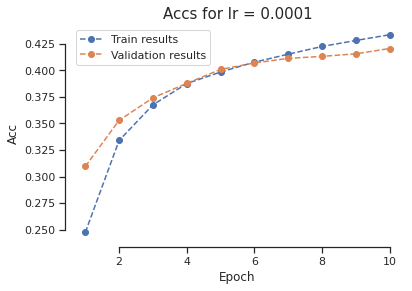

found lr=0.0001


In [29]:
lr = 1
for _ in range(5):
    early = EarlyStopper(patience=1,path=None)
    num_epochs = 10
    model = MLP(32,3,len(trainset.dataset.classes))
    model=model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                    trainloader, valloader, early_stopper=early, verbose=False)
    plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
    plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
    if(not early.early_stop):
        print(f"found lr={lr}")
        break
    
    lr/=10

In [ ]:
%matplotlib inline

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your todo's:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

Finished training after 1462 seconds.


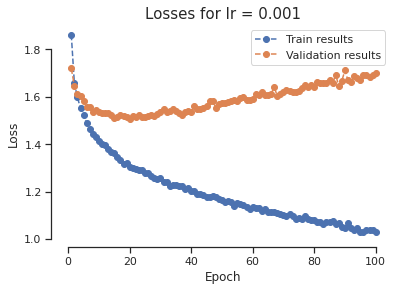

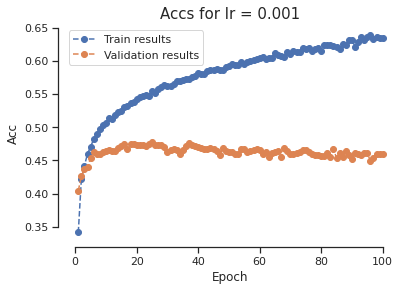

best val_loss: 1.508097243309021 at epoch: 19
best val_acc: 0.4773 at epoch: 24


In [145]:
####################
## YOUR CODE HERE ##
####################
lr = 1e-3
num_epochs = 100
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [31]:
#(*) for question 1
np.diff(train_losses) <= 0 #not monotonic

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False,  True, False,  True,  True, False,  True,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True])

In [32]:
# check if train_acc is monotonic increasing
np.diff(train_accs)>=0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True])

In [33]:
# check if val_acc is monotonic increasing
np.diff(val_accs)>=0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True, False,  True, False,
       False,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True, False, False, False,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True,  True])

In [ ]:
val_accs[46],val_accs[20]

Let's have a look at those training curves! Here are some questions for you.

#### TODO
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. The trend is that its decreasing, but its not monotonic decreasing, which can be seen in (*)
- its decreasing because it tries to fit the model to the training set, so a increasing/flattened curve would indicade that its not training. The non monotonic comes from noise from SGD probably/Adam
2. It decreases at the beginning, but starts to flatten after ~20 Epochs. It has its total min as seen below the plot at 45 Epochs
- Since the model trains on the train set, the learning there doesnt gurantees the improvement for the validation set.
3. Both accs increases at the beginning but starts to flatten out after ~20 Epochs for the val acc.
- The train acc seems to keep increasing (since it tries to memorize every picture[overfittig])
- as to see above its not monotonic increasing
4. Its different by 1 epoch but almost the same.
5.
6. Id choose the epoch where the model started to flatten, not exacly the max of acc since it will be noise, and the model could have overfitted (which still doesnt look like, since the val_acc is not dropping)
- i.e. 20 Epochs

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [146]:
####################
## YOUR CODE HERE ##
####################
# feel free to add more cells here
EPOCH = np.argmin(val_losses)+1
PATH = '/kaggle/working/model'
LOSS = min(val_losses)
torch.save(model.state_dict(), PATH)

In [148]:
lr = 1e-4
model2 = MLP(32,3,len(trainset.dataset.classes))
model2=model2.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
model2.eval()
mean_loss,acc,conf = validate(valloader, model2, loss_fn, device, master_bar=None)

In [149]:
print("validation set accuracy for untrained model2: ",acc)

validation set accuracy for untrained model2:  0.1099


In [150]:
model2.load_state_dict(torch.load(PATH)) #error after a change of MLP, didnt want to train again(it worked, just small adjustment of self.fc1)
model2.eval()

MLP(
  (hidden): ModuleList(
    (0): Linear(in_features=3072, out_features=30, bias=True)
  )
  (out): Linear(in_features=30, out_features=10, bias=True)
)

In [151]:
mean_loss,val_acc,conf = validate(valloader, model2, loss_fn, device, master_bar=None)
print("valset acc for original model:",val_accs[-1])

valset acc for original model: 0.4603


## Early stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [43]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt',patience=3):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
        """
        self.verbose=verbose
        self.path=path
        self.patience=patience
        self.val_acc=[]
        self._early_stop=False
        ####################
        ## YOUR CODE HERE ##
        #################False###

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        ####################
        ## YOUR CODE HERE ##
        ####################
        return self._early_stop
    def check(self):
        tau = self.patience
        if(len(self.val_acc)>=tau):
            if(sum(np.diff(self.val_acc[-tau-1:])<=0)==tau):
                self._early_stop=True
                print(f"didnt learn for {tau} epochs in a row")
    ####################
    ## YOUR CODE HERE ##
    ####################
    # define more methods required to make `EarlyStopper` functional

TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [44]:
ls

__notebook_source__.ipynb  data/  model  state.db


In [47]:
####################
## YOUR CODE HERE ##
####################
early_stopper=EarlyStopper(path="default_",patience=1)
lr = 1e-4
num_epochs = 100
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 1 epochs in a row
Finished training after 296 seconds.


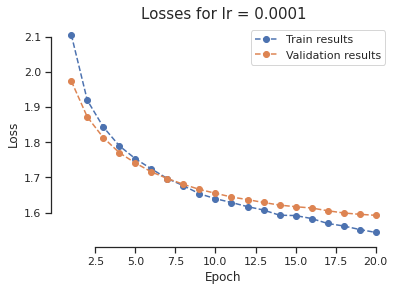

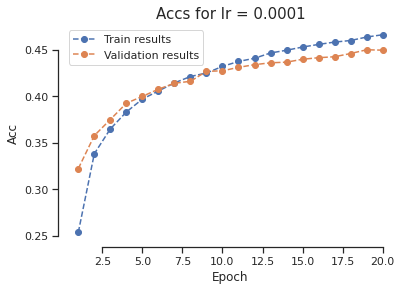

best val_loss: 1.5924944877624512 at epoch: 19
best val_acc: 0.4502 at epoch: 18


In [48]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

- It almost reaches the best model performance
    - weights are getting initialized random, so it also depends on init luck, the trend is that fewer epochs are enough

In [49]:
####################
## YOUR CODE HERE ##
####################

early_stopper=EarlyStopper(path="default_patience_2",patience=2)
lr = 1e-4
num_epochs = 100
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 896 seconds.


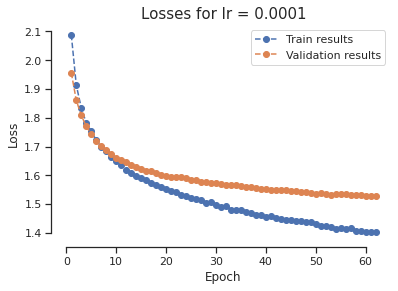

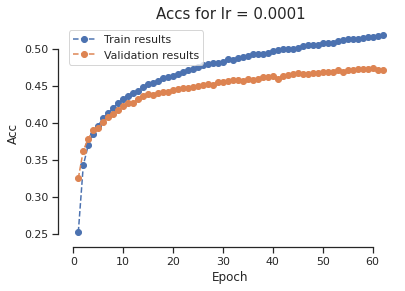

best val_loss: 1.5281233429908752 at epoch: 61
best val_acc: 0.4739 at epoch: 59


In [50]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [53]:
ls

default_/  default_patience_2/


## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

In [54]:
lr = 1e-3

####################
## YOUR CODE HERE ##
####################
early_stopper=EarlyStopper(path="lr_1e-3_patience_2",patience=2)
num_epochs = 100
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)


didnt learn for 2 epochs in a row
Finished training after 244 seconds.


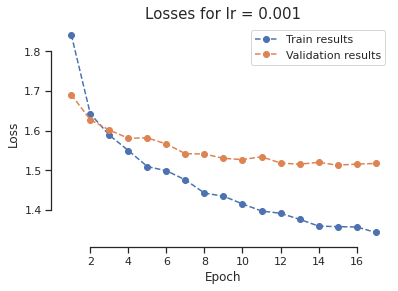

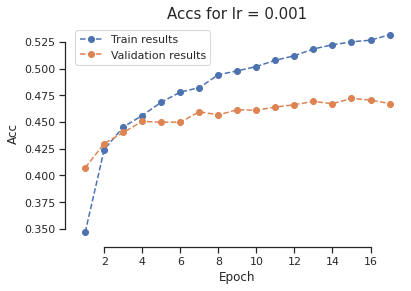

best val_loss: 1.5130460858345032 at epoch: 14
best val_acc: 0.4721 at epoch: 14


In [55]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

The model trained way shorter and got to a better result.
For further task ill use a lr=1e-3

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [56]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################
trainloader, valloader, testloader= init_data_loaders(trainset, valset,testset,batch_size=1)
lr = 1e-3

####################
## YOUR CODE HERE ##
####################
early_stopper=EarlyStopper(path="batchsize1",patience=2)
num_epochs = 1
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=None, verbose=False)


Finished training after 186 seconds.


In [58]:
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

best val_loss: 1.906282198725811 at epoch: 0
best val_acc: 0.3483 at epoch: 0


In [60]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

trainloader, valloader, testloader= init_data_loaders(trainset, valset,testset,batch_size=512)
lr = 1e-3
num_epochs=100
####################
## YOUR CODE HERE ##
####################
early_stopper=EarlyStopper(path="batchsize512",patience=10)
model = MLP(32,3,len(trainset.dataset.classes))
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)


Finished training after 1487 seconds.


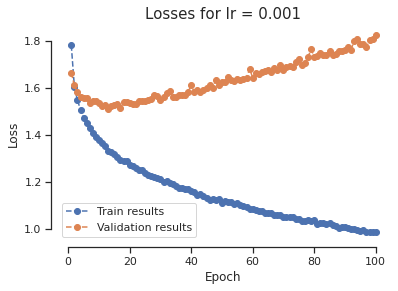

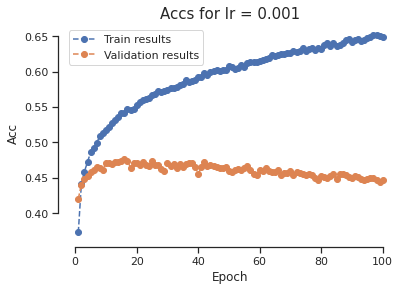

best val_loss: 1.5093487441539764 at epoch: 12
best val_acc: 0.476 at epoch: 15


In [61]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

seems to overfit, but with lower patience it gives a solid result.

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers
- activation function used

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [63]:
trainloader, valloader, testloader= init_data_loaders(trainset, valset,testset)

In [64]:
# number of hidden units

####################
## YOUR CODE HERE ##
####################
early_stopper=EarlyStopper(path="60_units",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),60)
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 440 seconds.


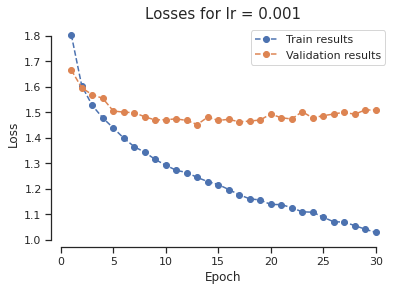

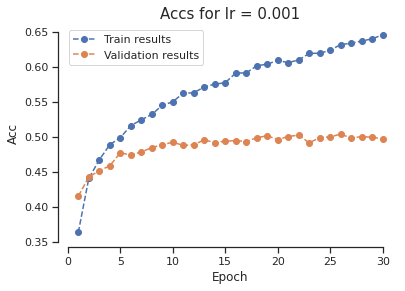

best val_loss: 1.452350389957428 at epoch: 12
best val_acc: 0.5042 at epoch: 25


In [65]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [89]:
early_stopper=EarlyStopper(path="300_units",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_units=300)
model=model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 116 seconds.


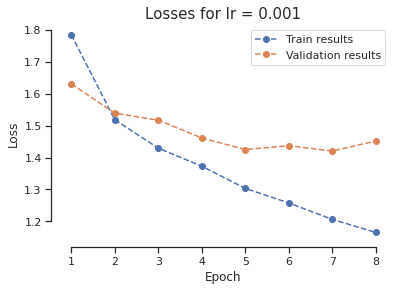

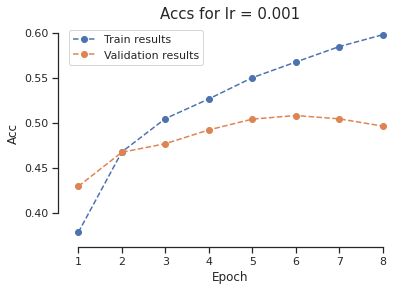

best val_loss: 1.4201914310455321 at epoch: 6
best val_acc: 0.508 at epoch: 5


In [90]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [66]:
# number of layers

####################
## YOUR CODE HERE ##
####################

early_stopper=EarlyStopper(path="2_layer",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=2)
loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 133 seconds.


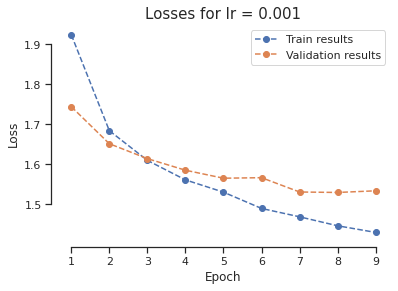

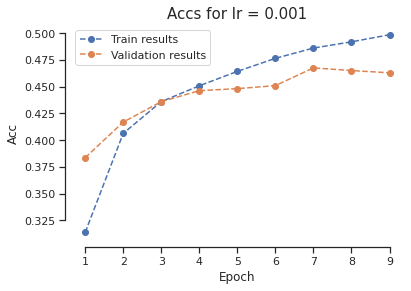

best val_loss: 1.5294989585876464 at epoch: 7
best val_acc: 0.4676 at epoch: 6


In [67]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [68]:
# activation function

####################
## YOUR CODE HERE ##
####################
act = nn.Tanh()
early_stopper=EarlyStopper(path="tanh",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=1,act_fn=act)

loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)


didnt learn for 2 epochs in a row
Finished training after 149 seconds.


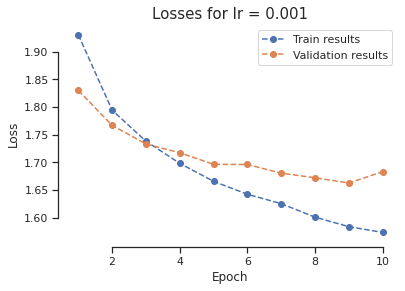

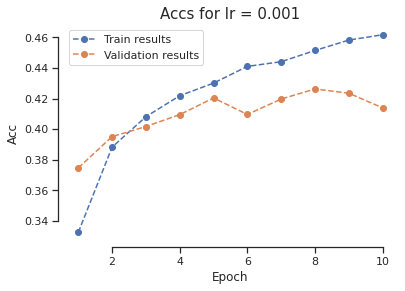

best val_loss: 1.6624478340148925 at epoch: 8
best val_acc: 0.4263 at epoch: 7


In [69]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [70]:
act = nn.ELU()
early_stopper=EarlyStopper(path="ELU",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=1,act_fn=act)

loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 264 seconds.


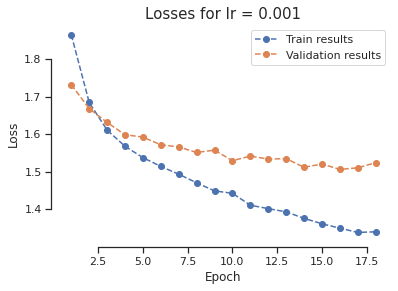

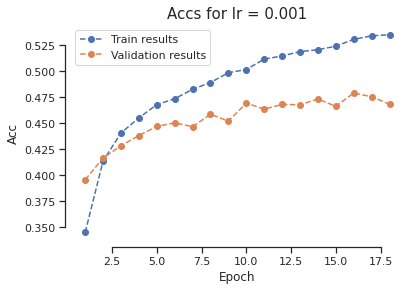

best val_loss: 1.505633783340454 at epoch: 15
best val_acc: 0.4791 at epoch: 15


In [71]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

In [112]:
act = nn.Tanhshrink()
early_stopper=EarlyStopper(path="Tanhshrink",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),act_fn=act)

loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

didnt learn for 2 epochs in a row
Finished training after 309 seconds.


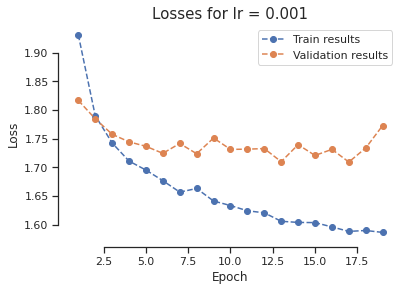

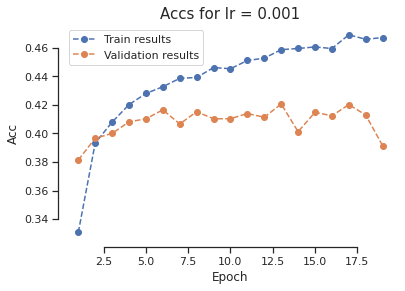

best val_loss: 1.709195649623871 at epoch: 16
best val_acc: 0.4206 at epoch: 12


In [113]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- around 50% acc was the best
- the number of units per layor made the largest different(in the positive direction)
- wider doesnt help in general since if you still have low number of units you lose information
    - bigger is also not always better, since the model with overfit and the val_acc will be poor

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

didnt learn for 2 epochs in a row
Finished training after 200 seconds.


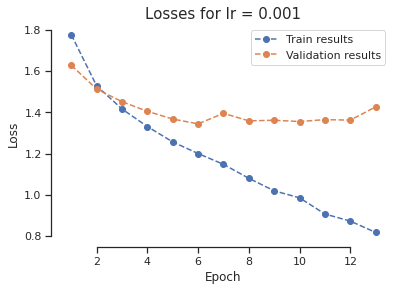

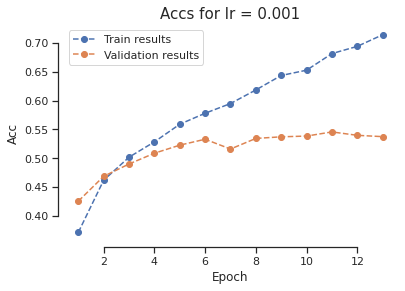

best val_loss: 1.3436380743980407 at epoch: 5
best val_acc: 0.5457 at epoch: 10


In [114]:
act = nn.ELU()
early_stopper=EarlyStopper(path="ELU_2_300",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),300,2,act_fn=act)

loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

Above is the model with the parameter, which performed seperately the best. It looks really good, even tho I wouldnt expect that to happen, since it usually would lead to strong overfitting (at a wide,deep network). It had a $lucky$ weight init for sure.

In [107]:
act = nn.ReLU()
early_stopper=EarlyStopper(path="ReLU_2_lay_300_units",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=2,act_fn=act,num_hidden_units=300)
loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85fa8cfe60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f85fa8cfe60>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

didnt learn for 2 epochs in a row
Finished training after 589 seconds.


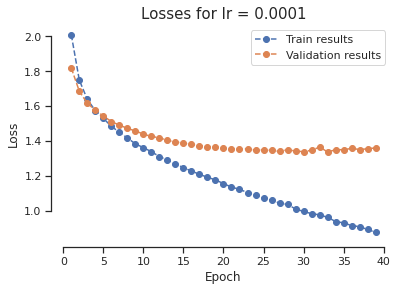

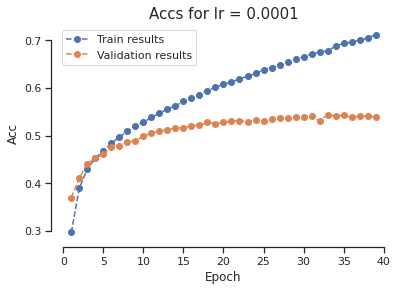

best val_loss: 1.3375528216362 at epoch: 32
best val_acc: 0.5438 at epoch: 32


In [109]:
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

They dont get the same performance, since they depend on initialization and SGD has randomnis inside.
- If the weights are actually random, we could set a seed.
- Since Adam uses SGD which contains random subsamples, we could implement a fixed subsample for every epoch, that every model uses the same samples.

didnt learn for 2 epochs in a row
Finished training after 358 seconds.


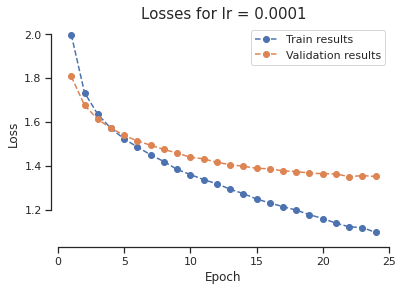

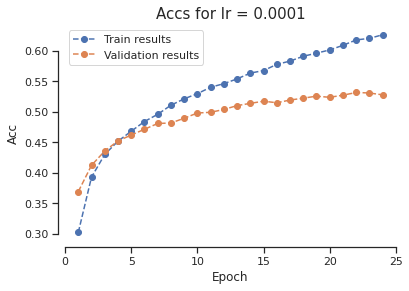

best val_loss: 1.3509382724761962 at epoch: 21
best val_acc: 0.5317 at epoch: 21


In [115]:
act = nn.ReLU() #best model trained 2 time
early_stopper=EarlyStopper(path="ReLU_2_lay_300_units",patience=2)
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=2,act_fn=act,num_hidden_units=300)
loss_function = torch.nn.CrossEntropyLoss()
num_epochs=100
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
train_losses, val_losses, train_accs, val_accs, confusion_matrix=run_training(model, optimizer, loss_function, device, num_epochs, 
                trainloader, valloader, early_stopper=early_stopper, verbose=False)
%matplotlib inline
plot("Losses for lr = {}".format(lr), "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
plot("Accs for lr = {}".format(lr), "Acc", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None)
print("best val_loss: {} at epoch: {}".format(min(val_losses),np.argmin(val_losses)))
print("best val_acc: {} at epoch: {}".format(max(val_accs),np.argmax(val_accs)))

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too! *(optional)*

In [121]:
act = nn.ReLU() #load best model at best epoch
model = MLP(32,3,len(trainset.dataset.classes),num_hidden_layers=2,act_fn=act,num_hidden_units=300)
loss_function = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model=model.to(device)
model.load_state_dict(torch.load("/kaggle/working/trained_models/ReLU_2_lay_300_units/model_for_epoch_21"))

<All keys matched successfully>

In [122]:
print(model)

MLP(
  (act_fn): ReLU()
  (hidden): ModuleList(
    (0): Linear(in_features=3072, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
  )
  (out): Linear(in_features=300, out_features=10, bias=True)
)


In [135]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    ## YOUR CODE HERE ##
    ####################
    loss_fn = torch.nn.CrossEntropyLoss()
    losses, accs, confusion_matrix =validate(test_loader, model, loss_fn, device, master_bar=None)
    return accs,confusion_matrix

accuracy of best model:0.5294


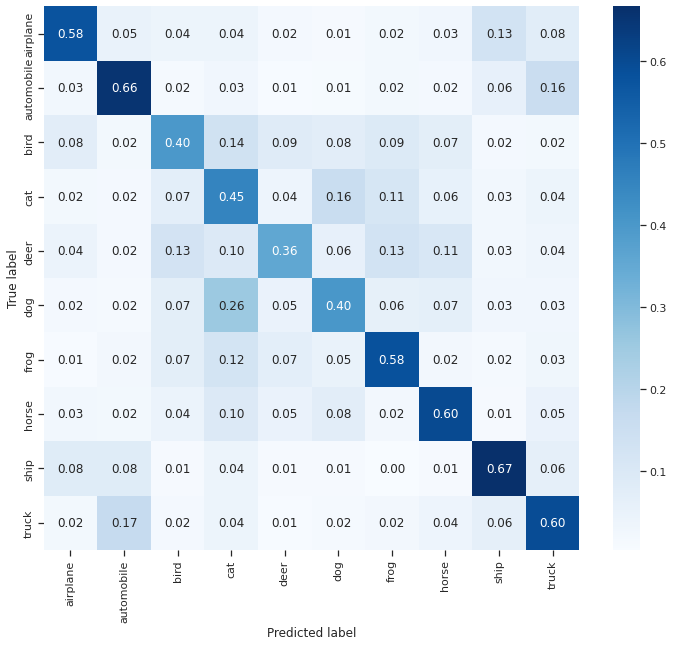

In [144]:
# The accuracy and confusion matrix

####################
## YOUR CODE HERE ##
####################
labels = trainset.dataset.classes
accs,conf=test(testloader,model,device)
for i in range(len(conf)):
    conf[i,:]/=sum(conf[i])
print(f"accuracy of best model:{accs}")
plt.figure(figsize=(12,10))
sns.heatmap(conf,annot=True,fmt='.2f',cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

- the model predicts mostly bad on animals, and better at "things"
- it confuses dogs to cats, which is reasonable, same for
- its almost the same, but slightly worse (test acc vs val acc)
- they are different because I chose the model at a epoch at which the validation acc is the best
    - this choice makes the model biased, since it depends on what is inside the validation set
    - since the testset will have a different structure/pictures its kinda impossible to be the same
- A model will overfit with respect to the set it trains on, if it gets the chance to
    - that choice would always leed to big networks and perform very bad on data it didnt see before